In [ ]:
import torch
import numpy as np
import json
from transformers import AutoTokenizer
import networkx as nx
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import hierarchical as hrc

device = torch.device("cuda:0")
MODEL_NAME = "google/gemma-2b"
g, _, _ = hrc.get_g(MODEL_NAME, device)
vocab_dict, vocab_list = hrc.get_vocab(MODEL_NAME)

In [2]:
cats, G, sorted_keys = hrc.get_categories('noun', 'gemma')
vec_reps = torch.load('FILE_PATH')

In [3]:
from networkx.drawing.nx_agraph import graphviz_layout
start_node = 'animal.n.01'
sub_G = nx.bfs_tree(G, start_node)
sub_G = nx.DiGraph(G.subgraph(sub_G.nodes()))

In [ ]:
pos = graphviz_layout(sub_G, prog='dot')
labels = {node: node.split('.', 1)[0] for node in sub_G.nodes()}

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
nx.draw_networkx_nodes(sub_G, pos, node_size=500, node_color='lightblue', alpha=0.2)
nx.draw_networkx_edges(sub_G, pos, edge_color='gray', width=2)
nx.draw_networkx_labels(sub_G, pos, labels=labels)

plt.axis('off')
plt.savefig(f"figures/sub_graph_noun.pdf", bbox_inches='tight')
plt.show()

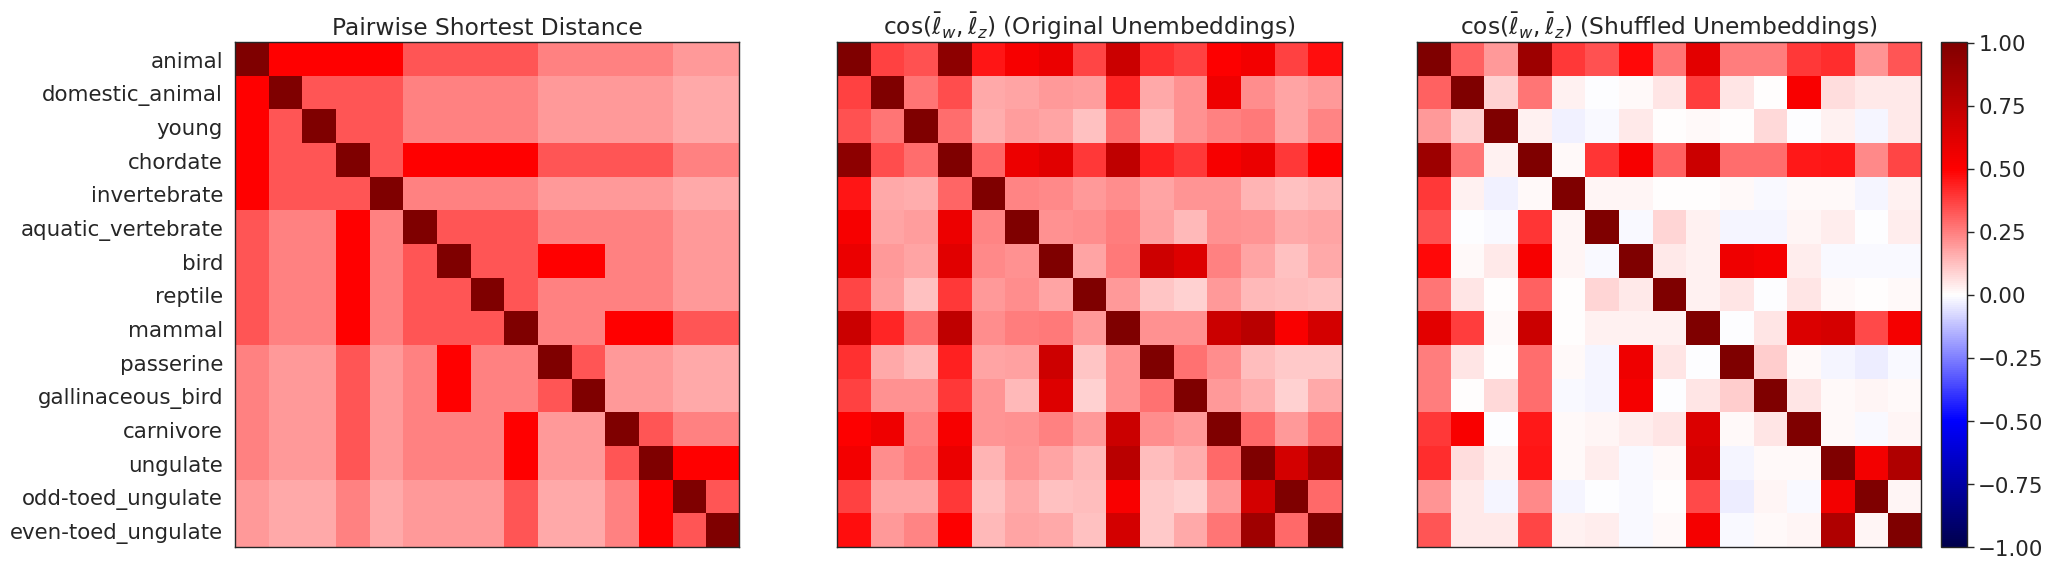

In [4]:
sub_sorted_keys = list(nx.topological_sort(sub_G))

sub_G_undirected = sub_G.to_undirected()
dist_matrix = nx.floyd_warshall_numpy(sub_G_undirected, nodelist=sub_sorted_keys)
dist_matrix = 1 / (dist_matrix+1)

original_dirs = torch.stack([vec_reps['original']['non_split'][node]['lda'] for node in sub_sorted_keys])
original_dirs  = original_dirs  / original_dirs .norm(dim = 1).unsqueeze(1)
shuffled_dirs = torch.stack([vec_reps['shuffled']['non_split'][node]['lda'] for node in sub_sorted_keys])
shuffled_dirs = shuffled_dirs / shuffled_dirs.norm(dim = 1).unsqueeze(1)

mats = [dist_matrix,
        (original_dirs @ original_dirs.T).cpu().numpy(),
        (shuffled_dirs @ shuffled_dirs.T).cpu().numpy()]

titles = ["Pairwise Shortest Distance",
        rf'$\cos(\bar{{\ell}}_{{w}}, \bar{{\ell}}_{{z}})$ (Original Unembeddings)',
        rf'$\cos(\bar{{\ell}}_{{w}}, \bar{{\ell}}_{{z}})$ (Shuffled Unembeddings)',]

hrc.cos_heatmap(mats, titles, figsize = (21, 6),
        labels = [node.split('.', 1)[0] for node in sub_sorted_keys],
                use_absvals=False, cmap = 'seismic',
                save_to = "figures/sub_heatmap_noun_gemma.pdf")